In [542]:
import scanpy as sc
import numpy as np
import seaborn as sns
from scipy.sparse import save_npz#,csc_matrix
from scipy.io import mmread
from scipy.stats import median_abs_deviation
import scrublet as scr

import matplotlib.pyplot as plt
from matplotlib import colors


plt.rcParams['figure.figsize']=(3,3) #rescale figures


In [543]:
sample="26"
nforce="4500"

pathin_filtered="/project/genomics/lianyun/CaIPACL/run_count_force"+nforce+"/run_count_22L0120"+sample+"/outs/filtered_feature_bc_matrix.h5"
pathin_raw="/project/genomics/lianyun/CaIPACL/run_count_force"+nforce+"/run_count_22L0120"+sample+"/outs/raw_feature_bc_matrix.h5"
pathout_qc="/home/hpc/lianyun.huang/singlecell/final4/output/output_qc"
pathout_data="/project/genomics/lianyun/CaIPACL/cp_from_homepath/data_final4"

# read filtered data
adata=sc.read_10x_h5(pathin_filtered)
adata.var_names_make_unique()
# read raw data
adata_raw=sc.read_10x_h5(pathin_raw)
adata_raw.var_names_make_unique()

print(adata)
print(adata_raw)


/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4500 × 32285
    var: 'gene_ids', 'feature_types', 'genome'
AnnData object with n_obs × n_vars = 235351 × 32285
    var: 'gene_ids', 'feature_types', 'genome'


/home/hpc/lianyun.huang/anaconda3/envs/xyb/lib/python3.11/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### visualize qc parameters

In [544]:
# mark mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")

# calculate qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=[20], log1p=True, inplace=True)
adata

AnnData object with n_obs × n_vars = 4500 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

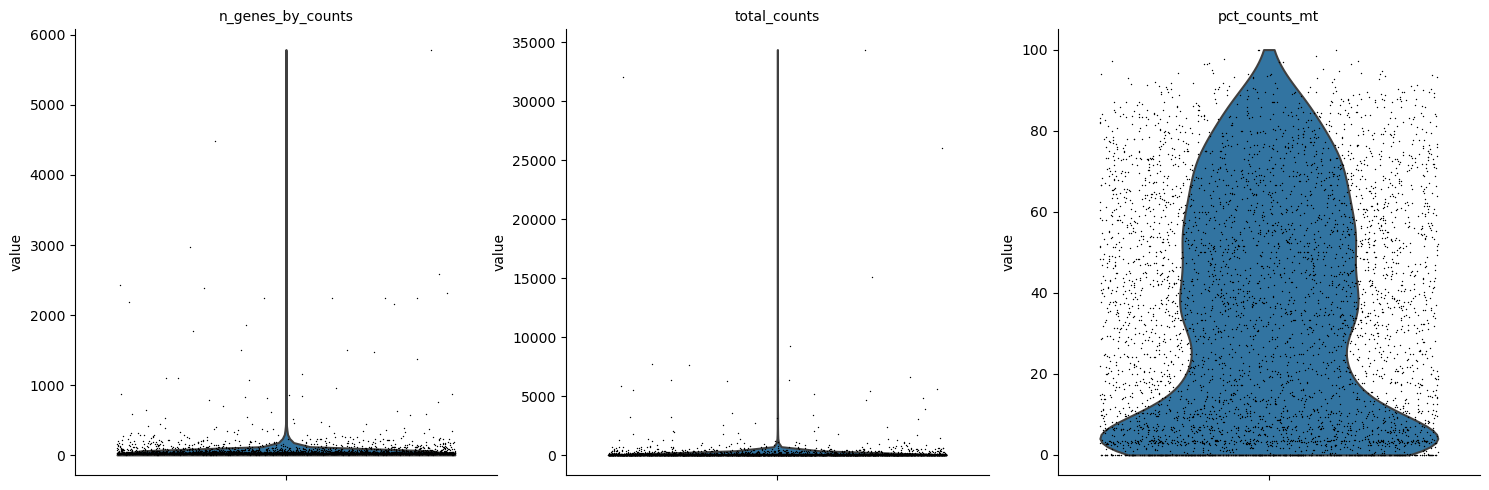

In [545]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True,show=False)
    plt.savefig(pathout_qc+"/qc_violin_sample"+sample+".pdf", bbox_inches="tight")

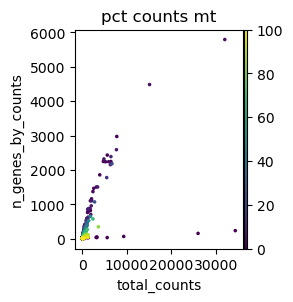

In [546]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',color="pct_counts_mt",show=False)
    plt.savefig(pathout_qc+"/qc_mtfrac_scatter_sample"+sample+".pdf", bbox_inches="tight")

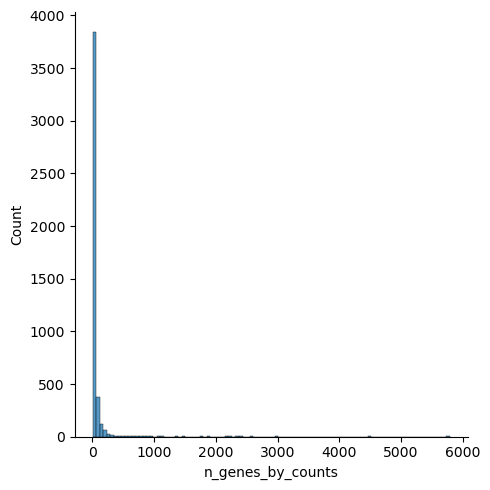

In [547]:
plttmp=sns.displot(adata.obs["n_genes_by_counts"], bins=100, kde=False)
plttmp.savefig(pathout_qc+"/qc_ngene_hist_sample"+sample+".pdf")

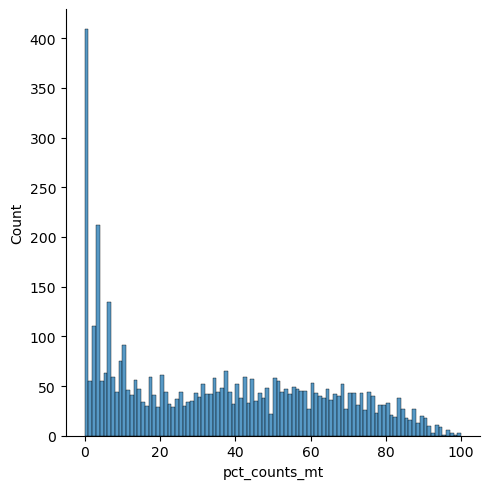

In [548]:
plttmp=sns.displot(adata.obs["pct_counts_mt"], bins=100, kde=False)
plttmp.savefig(pathout_qc+"/qc_mtfrac_hist_sample"+sample+".pdf")

### qc on MADs

In [549]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [550]:
# defaul thresholds as in the paper
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    4111
True      389
Name: count, dtype: int64

In [551]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 20
)
adata.obs.mt_outlier.value_counts()

mt_outlier
True     2790
False    1710
Name: count, dtype: int64

In [552]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 4500
Number of cells after filtering of low quality cells: 1568


In [553]:
adata

AnnData object with n_obs × n_vars = 1568 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### SoupX

In [554]:
# make a rough cluster for SoupX
adata_pp=adata.copy()

sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

In [555]:
# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]

cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

data_tod = adata_raw.X.T

In [556]:
# save variable for running SoupX in R
cells.to_series().to_csv(pathout_data+'/cells'+sample+'.csv', header=False)
genes.to_series().to_csv(pathout_data+'/genes'+sample+'.csv', header=False)
soupx_groups.to_csv(pathout_data+'/soupx_groups'+sample+'.csv', header=False)
save_npz(pathout_data+'/data'+sample+'.npz', data)
save_npz(pathout_data+'/data_tod'+sample+'.npz', data_tod)

In [557]:
# then it's a a bunch of SoupX analysis in R
# xxx
# xxx
# xxx => generated "out.mtx", the corrected count matrix

In [558]:
# read in out
out=mmread(pathout_data+"/out"+sample+".mtx")
out=out.toarray()
out

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [559]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
adata.X = adata.layers["soupX_counts"]
adata

AnnData object with n_obs × n_vars = 1568 × 32285
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts', 'soupX_counts'

In [560]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print(f"Number of genes after cell filter: {adata.n_vars}")


Total number of genes: 32285
Number of genes after cell filter: 1939


In [561]:
# some samples cannot run scrublet. 
# so i save a version before applying scrublet for combining samples later
print(sample)
adata.write(pathout_data+"/finalsoupx_sample"+sample+".h5ad")
adata

26


AnnData object with n_obs × n_vars = 1568 × 1939
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts', 'soupX_counts'

### doublets

In [562]:
adata.obs['doublet_score']= np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [563]:
scrub = scr.Scrublet(counts_matrix = adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.07
Detected doublet rate = 46.5%
Estimated detectable doublet fraction = 64.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 72.1%
Elapsed time: 0.4 seconds


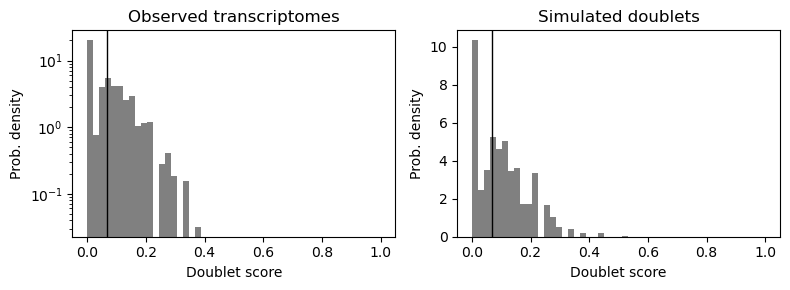

In [564]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    scrub.plot_histogram();
    plt.savefig(pathout_qc+"/qc_doublets_sample"+sample+".pdf", bbox_inches="tight")

In [565]:
doublet_thres=0.5

print(f"before filter out doublet: {adata.n_obs}")
print(f"threshold: {doublet_thres}")
print(f"after filter out doublet: {sum(adata.obs['doublet_score']<doublet_thres)}")



before filter out doublet: 1568
threshold: 0.5
after filter out doublet: 1568


In [566]:
adata = adata[adata.obs['doublet_score'] < doublet_thres]

print(sample)
adata.write(pathout_data+"/soupx_scrublet_sample"+sample+".h5ad")
adata

26


View of AnnData object with n_obs × n_vars = 1568 × 1939
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts', 'soupX_counts'